# 08wk-1,2: 생성모형 – Generative Adversarial Network (GAN)

최규빈  
2024-04-22

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/08wk-1-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-xfh-AQQI0B_GONOjgj9DCi&si=uWImDc1bYBoNqCB_>

# 2. Imports

In [1]:
import torch
import torchvision
import fastai.vision.all
import fastai.vision.gan
import matplotlib.pyplot as plt

# 3. GAN intro

`-` 저자: 이안굿펠로우 - 천재임 - 지도교수가 요수아 벤지오

`-` 논문 NIPS, 저는 이 논문 읽고 소름돋았어요.. -
https://arxiv.org/abs/1406.2661 (2021-09, 38751회 인용.. $\to$ 2022-09,
48978회 인용.. $\to$ 2024-03, 66609 인용..)

`-` 최근 10년간 머신러닝 분야에서 가장 혁신적인 아이디어이다. (얀르쿤,
2014년 시점..)

`-` 무슨내용? 생성모형

## A. 생성모형이란? (쉬운 설명)

> 만들수 없다면 이해하지 못한 것이다, 리처드 파인만 (천재 물리학자)

`-` 사진속에 들어있는 동물이 개인지 고양이인지 맞출수 있는 기계와 개와
고양이를 그릴수 있는 기계중 어떤것이 더 시각적보에 대한 이해가 깊다고 볼
수 있는가?

`-` 진정으로 인공지능이 이미지자료를 이해했다면, 이미지를 만들수도
있어야 한다. $\to$ 이미지를 생성하는 모형을 만들어보자 $\to$ 성공

![](https://upload.wikimedia.org/wikipedia/commons/1/1f/Woman_1.jpg)

## B. GAN의 응용분야

`-` 내가 찍은 사진이 피카소의 화풍으로 표현된다면?

`-` 퀸의 라이브에이드가 4k로 나온다면?

`-` 1920년대 서울의 모습이 칼라로 복원된다면?

`-` 딥페이크: 유명인의 가짜 포르노, 가짜뉴스, 협박(거짓기소)

`-` 거북이의 커버..

`-` 너무 많아요…..

## C. 생성모형이란? 통계학과 버전의 설명

> 제한된 정보만으로 어떤 문제를 풀 때, 그 과정에서 원래의 문제보다
> 일반적인 문제를 풀지 말고 (=문제를 괜히 어렵게 만들어서 풀지 말고),
> 가능한 원래의 문제를 직접 풀어야한다. 배프닉 (SVM 창시자)

`-` 이미지 $\boldsymbol{X}$ 가 주어졌을 경우 라벨을 $y$ 라고 하자.

`-` 이미지를 보고 라벨을 맞추는 일은 $p(y| \boldsymbol{X})$에 관심이
있다. – 판별모형

`-` 이미지를 생성하는 일은 $p(\boldsymbol{X},y)$에 관심이 있는것이다. –
생성모형

`-` 데이터의 생성확률 $p(\boldsymbol{X},y)$을 알면 클래스의 사후확률
$p(y|\boldsymbol{X})$를 알 수 있음. (아래의 수식 참고) 하지만 역은
불가능

$$p(y|{\boldsymbol X}) = \frac{p({\boldsymbol X},y)}{p({\boldsymbol X})} = \frac{p({\boldsymbol X},y)}{\sum_{y}p({\boldsymbol X},y)}$$

-   즉 이미지를 생성하는일은 분류문제보다 더 어려운 일이라 해석가능

`-` 따라서 배프닉의 원리에 의하면 일반적인 분류문제를 해결할때
“판별모형이 생성모형보다 더 바람직한 접근법”이라 할 수 있음. 즉 개와
고양이를 구분할 때, 그려진 개와 고양이 사진을 잘 구분하면 되는 것이지
굳이 개와 고양이를 그릴줄 알아야하는건 아니라는 의미.

`-` 예전에는 머신러닝의 응용분야가 “분류/회귀”에 한정된 느낌이었는데
요즘은 생성모형도 인기있음.

## D. GAN의 원리

`-` GAN은 생성모형 중 하나임

`-` GAN의 원리는 경찰과 위조지폐범이 서로 선의의(?) 경쟁을 통하여 서로
발전하는 모형으로 설명할 수 있다.

> The generative model can be thought of as analogous to a team of
> fakers, trying to produce fake currency and use it without detection,
> while the discriminative model is analogous to the police, trying to
> detect the counterfeit currency. Competition in this game drives both
> teams to improve their methods until the counterfeits are
> indistiguishable from the genuine articles.

`-` 서로 적대적인(adversarial) 네트워크(network)를 동시에 학습시켜
가짜이미지를 만든다(generate)

`-` 무식한 상황극..

-   위조범: 가짜돈을 만들어서 부자가 되어야지! (가짜돈을 그림)
-   경찰: (위조범이 만든 돈을 보고) 이건 가짜다!
-   위조범: 걸렸군.. 더 정교하게 만들어야지..
-   경찰: 이건 진짠가?… –\> 상사에게 혼남. 그것도 구분못하냐고 –\>
    (판별능력 업그레이드) –\> 이건 가짜다!!
-   위조범: 더 정교하게 만들자..
-   경찰: 더 판별능력을 업그레이드 하자!
-   반복..

`-` 굉장히 우수한 경찰조차도 진짜와 가짜를 구분하지 못할때(=진짜
이미지를 0.5의 확률로만 진짜라고 말할때 = 가짜 이미지를 0.5의 확률로만
가짜라고 말할때) 학습을 멈춘다.

# 4. GAN의 구현

## A. Data

In [2]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
path

Path('/root/.fastai/data/mnist_png')

In [3]:
X_real = torch.stack([torchvision.io.read_image(str(l)) for l in (path/'training/3').ls()],axis=0)/255
X_real.shape

torch.Size([6131, 1, 28, 28])

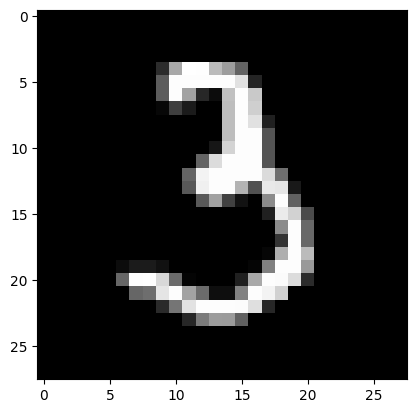

In [4]:
plt.imshow(X_real[0].reshape(28,28),cmap="gray") #리셰잎 안하면 안보임.

## B. 페이커 생성

> “net_faker: noise $\to$ 가짜이미지” 를 만들자.

`-` 네트워크의 입력: (n,??) 인 랜덤으로 뽑은 숫자.

`-` 네트워크의 출력: (n,1,28,28)의 텐서

In [5]:
torch.randn(1,4) # 이게 들어온다고 상상하자.

tensor([[-1.8228,  0.1859, -0.1587, -0.4206]])

In [6]:
class Reshape2828(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,X):
        return X.reshape(-1,1,28,28)

In [7]:
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784)
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주는 역할.. -- 저는 이 레이어가 일종의 문화충격이었어요.. (시그모이드를 이렇게 쓴다고??)
    Reshape2828() #이미지 모양을 만들기... ㄷㄷ;
)

In [8]:
net_faker(torch.randn(1,4)).shape # 가짜이미지!

torch.Size([1, 1, 28, 28])

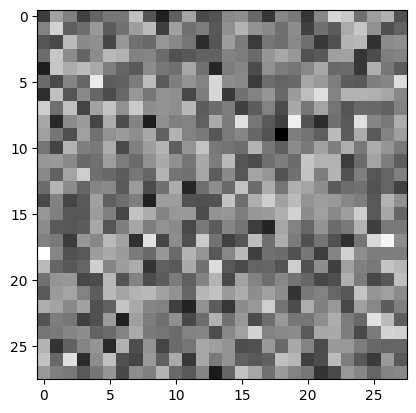

In [9]:
plt.imshow(net_faker(torch.randn(1,4)).detach().reshape(28,28),cmap = 'gray') #? 뭘 쳐만든겨

## C. 경찰 생성

> net_police: 진짜이미지 $\to$ 0 // 가짜이미지 $\to$ 1 와 같은
> 네트워크를 설계하자.

`-` 네트워크의 입력: (n,1,28,28) 인 이미지

`-` 네트워크의 출력: 0,1

In [10]:
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)

## D. 바보경찰, 바보페이커

> 스토리를 전개해볼까?

`-` 경찰네트워크가 가짜이미지를 봤을때 어떤 판단을 하는지, 진짜 이미지를
봤을떄 어떤 판단을 하는지 살펴보자.

***<경찰이 진짜이미지를 봤다면>***

`-` 진짜이미지

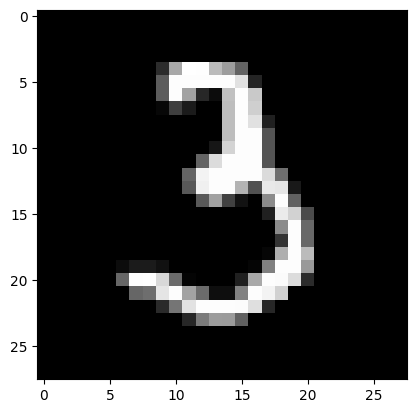

In [11]:
plt.imshow(X_real[0].reshape(28,28),cmap="gray")

`-` 진짜 이미지를 경찰한테 한장 줘볼까? $\to$ yhat이 나올텐데, 이 값이
0이어야 함

In [12]:
yhat_real = net_police(X_real[[0]]) # 이 값이 0이어야 하는데..
yhat_real

tensor([[0.5403]], grad_fn=<SigmoidBackward0>)

-   진짜 이미지가 입력으로 왔으므로 `yhat_real` $\approx$ `0` 이어야 함
-   그런데 0과 거리가 멀어보임. (=배운것이 없는 무능한 경찰)

***<경찰이 가짜이미지를 봤다면>***

`-` 가짜이미지 – 데이터셋이 있는게 아니고 net_faker가 생성해야하는
데이터

In [13]:
Noise = torch.randn(1,4)
Noise

tensor([[ 0.0703,  1.2201,  0.7404, -0.5370]])

In [14]:
net_faker(Noise).shape # 페이커가 만든 가짜 이미지

torch.Size([1, 1, 28, 28])

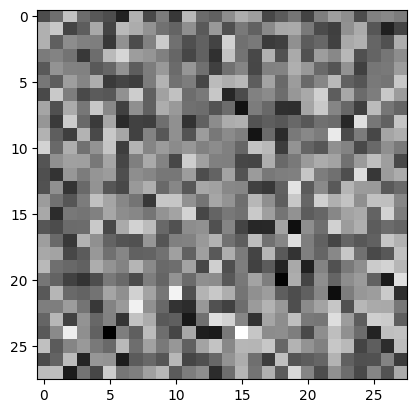

In [15]:
plt.imshow(net_faker(Noise).data.reshape(28,28),cmap="gray")

-   누가봐도 가짜이미지

`-` 가짜 이미지를 경찰한테 한장 줘볼까? $\to$ yhat이 나올텐데, 이 값이
1이어야 함

In [16]:
yhat_fake = net_police(net_faker(Noise)) # 이 값이 1이어야 하는데..
yhat_fake

tensor([[0.5231]], grad_fn=<SigmoidBackward0>)

-   가짜 이미지가 입력으로 왔으므로 `yhat_fake` $\approx$ `1` 이어야 함
-   그런데 1과 거리가 멀어보임. (=배운것이 없는 무능한 경찰)

`-` 페이커의 무능함 (왼쪽 이미지를 가짜이미지라고 만들어 놓았음) + 경찰의
무능함 (왼쪽과 오른쪽을 보고 뭐가 진짜인지도 모름)

Text(0.5, 1.0, 'real')

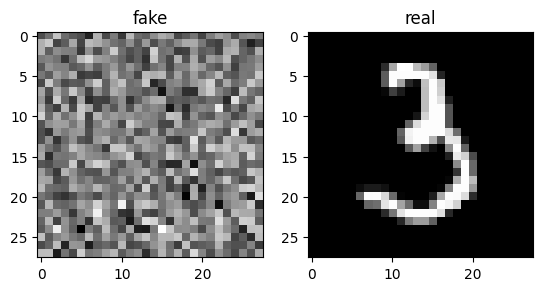

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(net_faker(Noise).data.reshape(28,28),cmap="gray"); ax[0].set_title("fake")
ax[1].imshow(X_real[[0]].reshape(28,28),cmap="gray"); ax[1].set_title("real")

## E. 똑똑해진 경찰

In [18]:
X_real.shape

torch.Size([6131, 1, 28, 28])

`-` 데이터 정리 - 원래 $n=6131$개의 이미지 자료가 있음. 이를
${\bf X}_{real}$ 라고 하자. 따라서 ${\bf X}_{real}$ 의 차원은
(6131,1,28,28). - 위조범이 만든 가짜자료를 원래 자료와 같은 숫자인
6131개 만듦. 이 가짜자료를 ${\bf X}_{fake}$ 라고 하자. 따라서
${\bf X}_{fake}$ 의 차원은 (6131,1,28,28). - 진짜자료는 0, 가짜자료는
1으로 라벨링.

In [19]:
Noise = torch.randn(6131,4)
X_fake = net_faker(Noise)
y_real = torch.tensor([0]*6131).reshape(-1,1).float()
y_fake = torch.tensor([1]*6131).reshape(-1,1).float()

`-` step1: X_real, X_fake를 보고 각가 yhat_real, yhat_fake를 만드는 과정

In [20]:
yhat_real = net_police(X_real) #0근처여야 좋고
yhat_fake = net_police(X_fake) #1근처여야 좋고

`-` step2: 손실을 계산 – 경찰의 미덕은 (1) 가짜이미지를 가짜라고 하고
(yhat_fake $\approx$ y_fake) (2) 진짜이미지를 진짜라고 해야한다.
(yhat_real $\approx$ y_real)

In [21]:
bce = torch.nn.BCELoss()
loss_police = bce(yhat_fake,y_fake) + bce(yhat_real,y_real)
loss_police

tensor(1.4323, grad_fn=<AddBackward0>)

`-` step3~4는 별로 특별한게 없음. 그래서 바로 epoch을 진행시켜보자.

In [22]:
##
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters())
##
for epoc in range(30):
    Noise = torch.randn(6131,4)
    X_fake = net_faker(Noise)
    ## step1
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)
    ## step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake)
    ## step3
    loss_police.backward()
    ## step4
    optimizr_police.step()
    optimizr_police.zero_grad()

`-` 훈련된 경찰의 성능을 살펴보자.

In [23]:
net_police(X_real) # 거의 0으로!

tensor([[0.0692],
        [0.0456],
        [0.2886],
        ...,
        [0.0575],
        [0.0541],
        [0.0311]], grad_fn=<SigmoidBackward0>)

In [24]:
net_police(X_fake) # 거의 1로!

tensor([[0.9856],
        [0.9854],
        [0.9856],
        ...,
        [0.9856],
        [0.9855],
        [0.9853]], grad_fn=<SigmoidBackward0>)

`-` 꽤 우수한 경찰이 되었음

Text(0.5, 1.0, 'real')

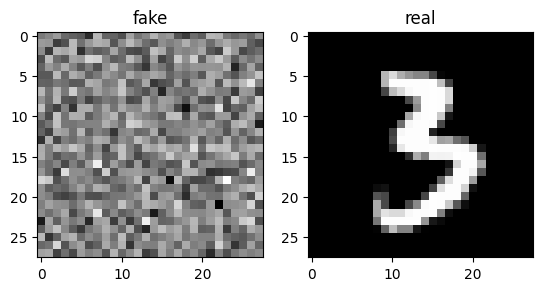

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_fake[[-1]].data.reshape(28,28),cmap="gray"); ax[0].set_title("fake")
ax[1].imshow(X_real[[-1]].reshape(28,28),cmap="gray"); ax[1].set_title("real")

## F. 더 똑똑해지는 페이커

`-` step1: Noise $\to$ X_fake

In [26]:
Noise = torch.randn(6131,4)
X_fake = net_faker(Noise)

`-` step2: 손실함수 – 페이커의 미덕은 (잘 훈련된) 경찰이 가짜이미지를
진짜라고 판단하는 것. 즉 `yhat_fake` $\approx$ `y_real` 이어야 페이커의
실력이 우수하다고 볼 수 있음.

In [27]:
yhat_fake = net_police(X_fake)
loss_faker = bce(yhat_fake,y_real) ## 가짜이미지를 보고 잘 훈련된 경찰조차 진짜이미지라고 깜빡 속으면 위조범의 실력이 좋은 것임

`-` step3~4는 별로 특별한게 없음. 그래서 바로 epoch을 진행시켜보자.

In [28]:
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784)
    torch.nn.Sigmoid(), # 출력을 0~1로 눌러주는 역할.. -- 저는 이 레이어가 일종의 문화충격이었어요.. (시그모이드를 이렇게 쓴다고??)
    Reshape2828()
)
#bce = torch.nn.BCELoss()
optimizr_faker = torch.optim.Adam(net_faker.parameters())
#--#

In [53]:
for epoc in range(1):
    # step1
    Noise = torch.randn(6131,4)
    X_fake = net_faker(Noise)
    # step2
    yhat_fake = net_police(X_fake) #경찰이 위조 여부를 판단하는 것..
    loss_faker = bce(yhat_fake,y_real) #위조범의 생성값이, 진짜 y로 보이는 것이 목표임.. (학습의 목적!)
    # step3
    loss_faker.backward()
    # step4
    optimizr_faker.step()
    optimizr_faker.zero_grad()

`-` 위조범의 실력향상을 감상해보자.

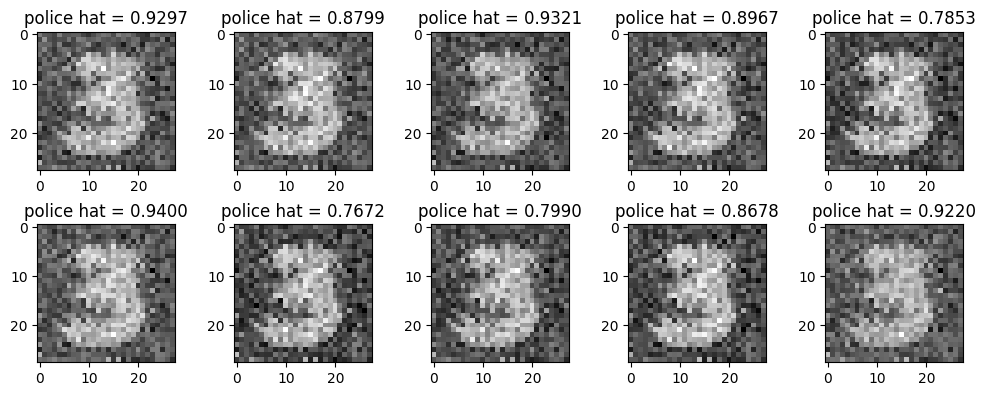

In [54]:
fig,ax = plt.subplots(2,5,figsize=(10,4))
k = 0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1
fig.tight_layout()

In [55]:
((yhat_fake > 0.5) == 0).float().mean() # 경찰이 가짜이미지를 진짜라고 생각한 비율 = 페이커가 사기에 성공한 비율
#한 20번 정도 학습하니까 10퍼센트 정도 속음.

tensor(0.0041)

## G. 경쟁학습

> 두 적대적인 네트워크를 경쟁시키자!

In [56]:
torch.manual_seed(43052)
net_police = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=784,out_features=30),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=30,out_features=1),
    torch.nn.Sigmoid()
)
net_faker = torch.nn.Sequential(
    torch.nn.Linear(in_features=4, out_features=64), # (n,4) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=64), # (n,64) -> (n,64)
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=784), # (n,64) -> (n,784)
    torch.nn.Sigmoid(), #충격 적인 레이어라고 하셨음 ㅋㅋ
    Reshape2828()
)
bce = torch.nn.BCELoss()
optimizr_police = torch.optim.Adam(net_police.parameters(),lr=0.001,betas=(0.5,0.999)) #조금더 빠른 학습  뒤에는 Adam 관련된 옵션
optimizr_faker = torch.optim.Adam(net_faker.parameters(),lr=0.0002,betas=(0.5,0.999)) #조금 더 느린 학습

In [57]:
for epoc in range(1000):
    # net_police 을 훈련
    Noise = torch.randn(6131,4)
    X_fake = net_faker(Noise).data # net_faker에 대한 미분꼬리표는 여기선 필요없으므로 .data 만을 이용
    ## step1
    yhat_real = net_police(X_real)
    yhat_fake = net_police(X_fake)
    ## step2
    loss_police = bce(yhat_real,y_real) + bce(yhat_fake,y_fake) #경찰은 잘 맞추기를 기대
    ## step3
    loss_police.backward()
    ## step4
    optimizr_police.step()
    optimizr_police.zero_grad()
    # net_faker 를 훈련
    ## step1
    Noise = torch.randn(6131,4)
    X_fake = net_faker(Noise)
    ## step2
    yhat_fake = net_police(X_fake)
    loss_faker = bce(yhat_fake,y_real) #경찰이 진짜와 가짜를 헷갈리길 기대
    ## step3
    loss_faker.backward()
    ## step4
    optimizr_faker.step()
    optimizr_faker.zero_grad()

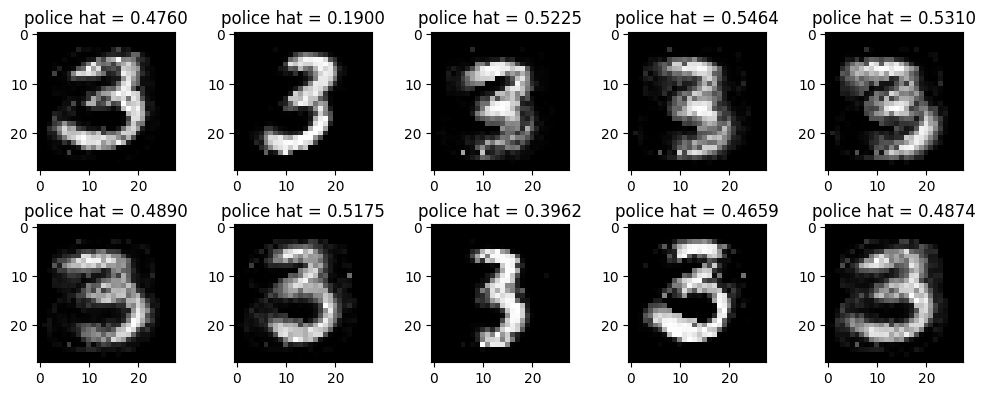

In [58]:
fig,ax = plt.subplots(2,5,figsize=(10,4))
k = 0
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(X_fake[k].reshape(28,28).data,cmap="gray")
        ax[i][j].set_title(f"police hat = {yhat_fake[k].item():.4f}")
        k = k+1
fig.tight_layout()

# 5. 초기 GAN의 한계점

`-` 두 네트워크의 균형이 매우 중요함 – 균형이 깨지는 순간 학습은 실패함

`-` 생성되는 이미지의 다양성이 부족함 (mode collapse)

-   사실 강의노트의 4-G 역시 동일이미지가 반복되고 있으므로 엄밀하게
    따지면 실패한 구현임